In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, dyngenCircle, SymsimCycle
from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder
from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [4]:
# dataBifur = SymsimBifur()
dataTree = SymsimTree()
# dataBranch = SymsimBranch()
# datalinear = SymsimLinear()
dataCircle = SymsimCycle()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataTree.num_features

300

In [72]:
def backbone_finding(data, n_randwk = 300, window_size = 20, step_size = 10, n_neighs = 30, resolution = 0.3, style = 'tree', threshold = 0):
    X = data.x
    y = data.y.squeeze()
    if isinstance(X, torch.Tensor):
        X = X.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    X_pca = utils.pca_op(X, n_comps=30, standardize=False)
    randwk = backbone.random_walk(X_pca, y, t_max = 10000, i_max = n_randwk, k = 5)
    seg = backbone.segmentation(randwk, X_pca[:,:4], cell_backbone=None, wind_size = window_size, step = step_size, y = y)
    seg_pca = utils.pca_op(seg['seg_features'], n_comps=30, standardize=False)
    conn, G = backbone.nearest_neighbor(seg_pca, k = n_neighs)
    groups, n_clusters = backbone.leiden(conn, resolution = resolution, n_iterations = -1)
    print('number of clusters: ', int(np.max(groups))+1)
    adj_groups = backbone.retrieve_conn(seg, groups)
    group_pt = mean_pt(groups, seg, y)
    if style == 'tree':
        T = pt_mst(adj_groups, group_pt)
        # T = backbone.post_processing_tree(adj_groups)

    elif style == 'pruning':
        T = post_processing_pruning(adj_groups, diff_thd=threshold)
    else:
        raise ValueError("only between tree and pruning")
    cell_bb = backbone.cell_clust_assign(seg = seg, X = X, groups = groups)
    
    results = {'seg': seg, 'seg_groups': groups, 'cell_groups': cell_bb, 'mst': T, 'origin_conn': adj_groups, 'X': X, 'y': y}
    return results

In [73]:
def mean_pt(groups, seg, y):
    segment = seg['segments']
    pt = np.array([np.mean(y[segment[i]]) for i in range(segment.shape[0])])
    group_pt = []
    for group in np.unique(groups):
        indices = np.where(groups == group)[0]
        group_pt.append(np.mean(pt[indices]))
    return np.array(group_pt)

In [74]:
def pt_mst(adj, mean_pt):
    source = np.argmin(mean_pt)
    cover = np.array([False for i in range(adj.shape[0])])
    cover[source] = True
    T = np.zeros_like(adj)
    while not np.all(cover):
        mst_indices = np.where(cover == True)[0]
        candidates = np.zeros_like(mst_indices)
        pool = np.zeros_like(mst_indices)
        for idx, curr in enumerate(mst_indices):
            candidate = [x for x in range(adj.shape[0]) if adj[curr, x]!=0 and cover[x] == False and mean_pt[x] - mean_pt[curr] >= 0]
            if candidate != []:
                candidate = candidate[np.argmax(adj[curr, candidate])]
                candidates[idx] = candidate
                pool[idx] = adj[curr, candidate]
        candidate = candidates[np.argmax(pool)]
        cover[candidate] = True
        T[mst_indices[np.argmax(pool)], candidate] = T[candidate, mst_indices[np.argmax(pool)]] = True
    return T

# pruning better than mst


In [75]:
data = dataCircle[3]
# Use segments rather than original single cell data, much denser, have as many segments as possible. higher probability to pass through the small branches. connection of random walk further provide connection information that constraint the mst construction.
# a segment is a smoothed version of cell data, in theory, better preserve the small branches while eliminate erroneous edges
# results1 = backbone.backbone_finding(data, style = 'pruning', threshold = 30)
results2 = backbone_finding(data, style = 'tree')

running Leiden clustering
finished
number of clusters:  11
empty cluster:  9


NameError: name 'T2' is not defined

In [62]:
results1 = results2.copy()
results1['mst'] = results1['mst2']

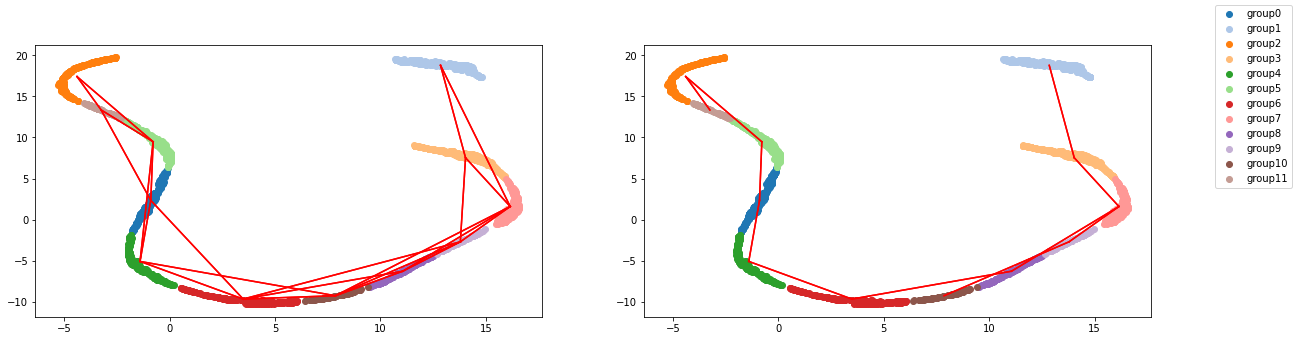

In [44]:
backbone.plot_backbone(results1, version = 'segment', figsize = (20,5))

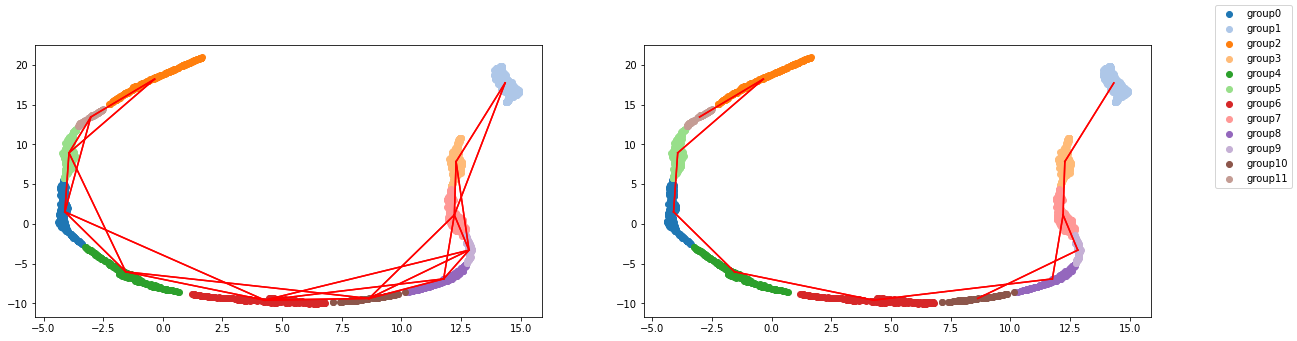

In [45]:
backbone.plot_backbone(results2, version = 'segment', figsize = (20,5))

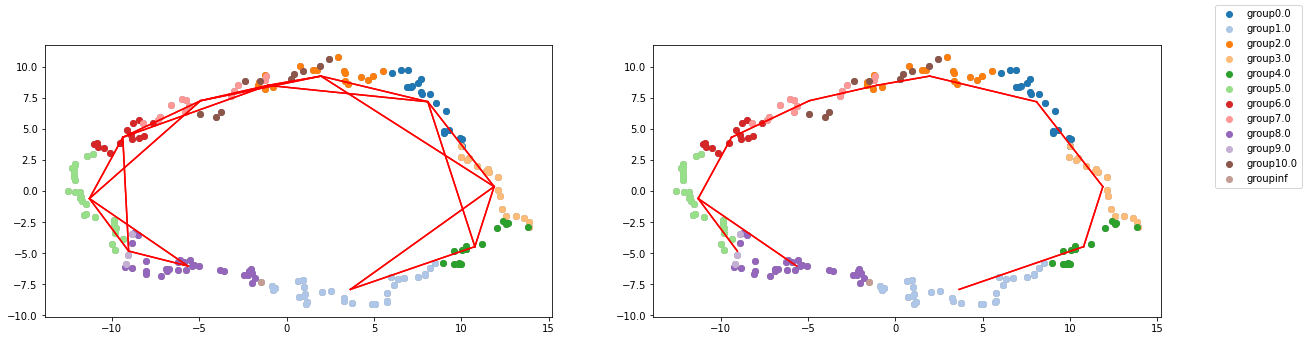

In [63]:
backbone.plot_backbone(results1, version = 'cell', figsize = (20,5))

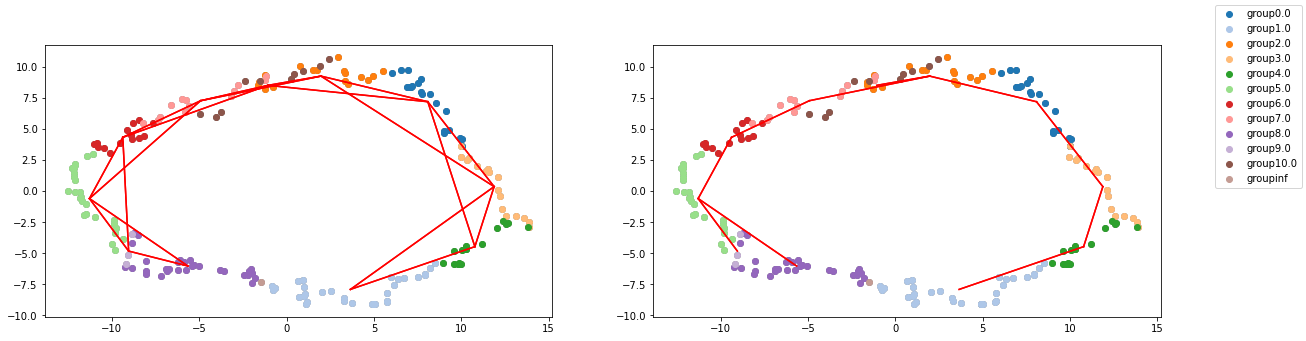

In [64]:
backbone.plot_backbone(results2, version = 'cell', figsize = (20,5))

# We cannot prove that our method out perform leiden on pca

In [66]:
results = results2

running Leiden clustering
finished
9


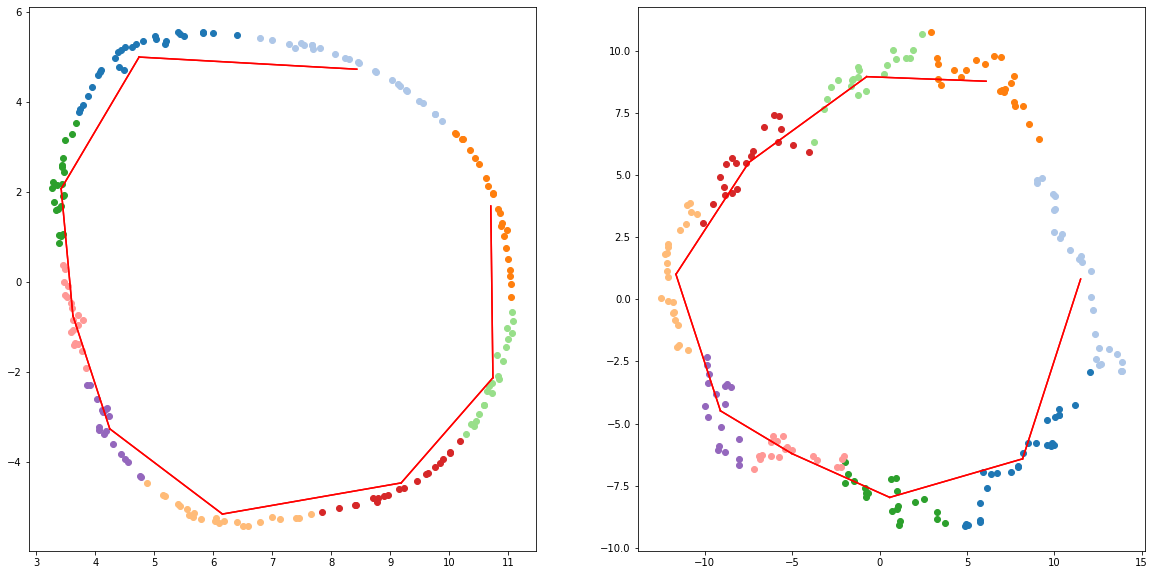

In [67]:
import umap
import networkx as nx
Umap = umap.UMAP(n_components=2)
X = results['X']
X_pca = utils.pca_op(X, n_comps=30,standardize=False)
conn, G = backbone.nearest_neighbor(X, k = 15)
groups, n_clust = backbone.leiden(conn, resolution=0.9)
print(n_clust)
X_umap = Umap.fit_transform(X)

mean_cluster = [[] for x in range(n_clust)]
mean_cluster2 = [[] for x in range(n_clust)]

fig = plt.figure(figsize = (20,10))
ax1, ax2 = fig.subplots(1,2)
cmap = plt.get_cmap('tab20')
for i, cat in enumerate(np.unique(groups)):
    idx = np.where(groups == cat)[0]
    cluster = ax1.scatter(X_umap[idx,0], X_umap[idx,1], color = cmap(i), cmap = 'tab20')
    cluster.set_label("group"+str(cat))
    mean_cluster[int(cat)] = [np.mean(X_umap[idx,0]), np.mean(X_umap[idx,1])] 
    mean_cluster2[int(cat)] = np.mean(X_pca[idx,:], axis = 0)

for i, cat in enumerate(np.unique(groups)):
    idx = np.where(groups == cat)[0]
    cluster = ax2.scatter(X_pca[idx,0], X_pca[idx,1], color = cmap(i), cmap = 'tab20')
    cluster.set_label("group"+str(cat))

mst = np.zeros((n_clust,n_clust))

for i in range(n_clust):
    for j in range(n_clust):
        mst[i,j] = np.linalg.norm(np.array(mean_cluster2[i]) - np.array(mean_cluster2[j]), ord = 2)

G = nx.from_numpy_matrix(-mst)
T = nx.maximum_spanning_tree(G, weight = 'weight', algorithm = 'kruskal')
T = nx.to_numpy_matrix(T)

conn = T 

for i in range(conn.shape[0]):
    for j in range(conn.shape[1]):
        if conn[i,j] != 0:
            ax1.plot([mean_cluster[i][0], mean_cluster[j][0]], [mean_cluster[i][1], mean_cluster[j][1]], 'r-')
            ax2.plot([mean_cluster2[i][0], mean_cluster2[j][0]], [mean_cluster2[i][1], mean_cluster2[j][1]], 'r-')